<a href="https://colab.research.google.com/github/lbattioni/DS_coder_house/blob/main/LucianoBattioniDIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentación del proyecto

## Abstracto

Durante la pandemia de COVID 19 cuantiosos recursos económicos se destinaron a la compra de insumos para la atención de pacientes.
LA compra de estos insumos en CABA se encuentra publicada en su repositorio público para favorecer la transparencia.
Sin embargo, el detalle de la compra, aún al estar publicado, es de dificil análisis, debido a que es un campo de texto libre y son miles de entradas.
Mediante técnicas de NLP se podria transmitir a la ciudadanía en que se gastaron los fondos públicos en la pandemia

##  Contexto comercial y analítico

La utilización de fondos públicos en contextos de excepción siempre da lugar a excepticísmo por parte de la población general. De igual manera, durante la pandemia de COVID 19, la mayoría de los efectores de salud reclamaban mejoras en el equipamiento o falta del mismo directamente.
La ciudad de buenos aires presenta una política de datos abiertos que permite a la ciudadanía comprender como se utilizan los fondos públicos. Sin embargo, la granularidad del dato es de dificil compresión. Este es el caso de los insumos adquiridos durante la pandemia, donde el detalle de la compra es de dificil ubiación, categorización y comprensión.
Sería beneficioso, tanto para la gestión que transitó la pandemia y para la ciudadanía poder comprender en que se gastó el dinero de las arcas del estado.


## Hipótesis y Objetivo

Generar insights de los insumos adquiridos durante la pandemia.

# Obtención de datos
## Librerías

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy


In [46]:
def detectar_caracteres_especiales(texto):
    especiales = re.findall(r'[^a-zA-Z0-9áéíóúñü\s]', texto)
    return len(especiales)

In [47]:
corpus=pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-economia-y-finanzas/compras-coronavirus/compras-coronavirus.csv'
            ,encoding='latin-1'
            ,sep=';'
            ,usecols=['descripcion'])

In [48]:
corpus.head()

,descripcion
0,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....
1,MICROPIPETA AUTOMATICA Modelo: De volumen vari...
2,MICROPIPETA AUTOMATICA Modelo: De volumen vari...
3,"PUNTA PARA PIPETA (TIP) Modelo: Azul, plástica"
4,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....


## Análisis exploratorio

PRE remoción de STOPWORDS, caracteres especiales, etc.

In [49]:
#forma del corpus
print(f'forma del corpus{corpus.shape}')
#datos nulos del corpus
print(f'datos nulos del corpus{corpus.isnull().sum()}')
corpus.dropna(inplace=True)
corpus.reset_index(drop=True)
corpus['caracteres_por_fila'] = corpus.apply(lambda x: len(x.descripcion), axis=1)
corpus['palabras_por_fila'] = corpus.apply(lambda x: len(x.descripcion.split()), axis=1)
corpus['caracteres_especiales_por_fila'] = corpus.apply(lambda x: detectar_caracteres_especiales(x.descripcion), axis=1)
corpus['oraciones_por_fila']=corpus.apply(lambda x: len(x.descripcion.split('.')), axis=1)
#caracteres promedio por fila
print(f"caracteres promedio por fila {corpus['caracteres_por_fila'].mean()}")
#conteo de palabras
print(f"conteo de palabras del corpus total {corpus['palabras_por_fila'].sum()}")
#promedio de palabras por fila
print(f"conteo de palabras por fila {corpus['palabras_por_fila'].mean()}")
#promedio de caracteres especiales por fila
print(f"promedio de caracteres especiales por fila {corpus['caracteres_especiales_por_fila'].mean()}")
#promedio de oraciones por fila:
print(f"promedio de oraciones por fila {corpus['oraciones_por_fila'].mean()}")
corpus.head()


forma del corpus(1798, 1)
datos nulos del corpusdescripcion    354
dtype: int64
caracteres promedio por fila 316.9639889196676
conteo de palabras del corpus total 71608
conteo de palabras por fila 49.59002770083102
promedio de caracteres especiales por fila 12.455678670360111
promedio de oraciones por fila 4.237534626038781


,descripcion,caracteres_por_fila,palabras_por_fila,caracteres_especiales_por_fila,oraciones_por_fila
0,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....,188,26,6,4
1,MICROPIPETA AUTOMATICA Modelo: De volumen vari...,253,37,8,2
2,MICROPIPETA AUTOMATICA Modelo: De volumen vari...,251,38,8,2
3,"PUNTA PARA PIPETA (TIP) Modelo: Azul, plástica",46,7,4,1
4,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....,188,26,6,4


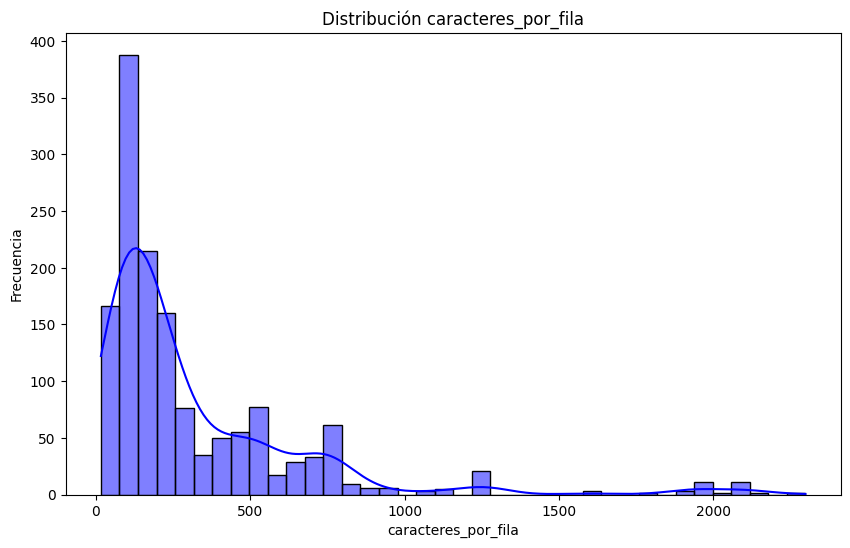

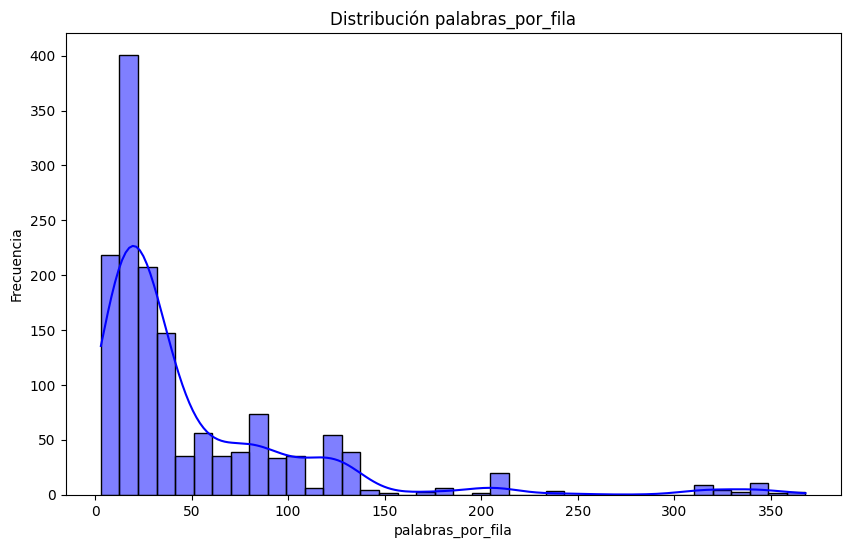

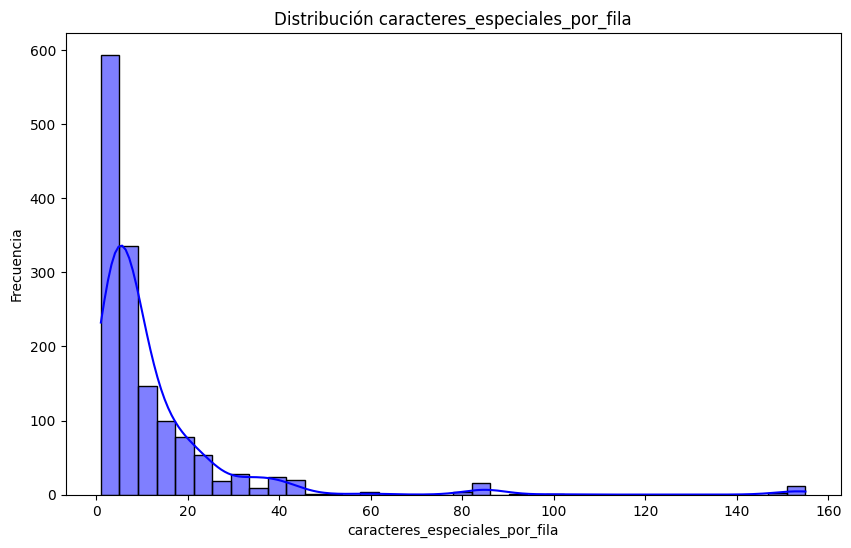

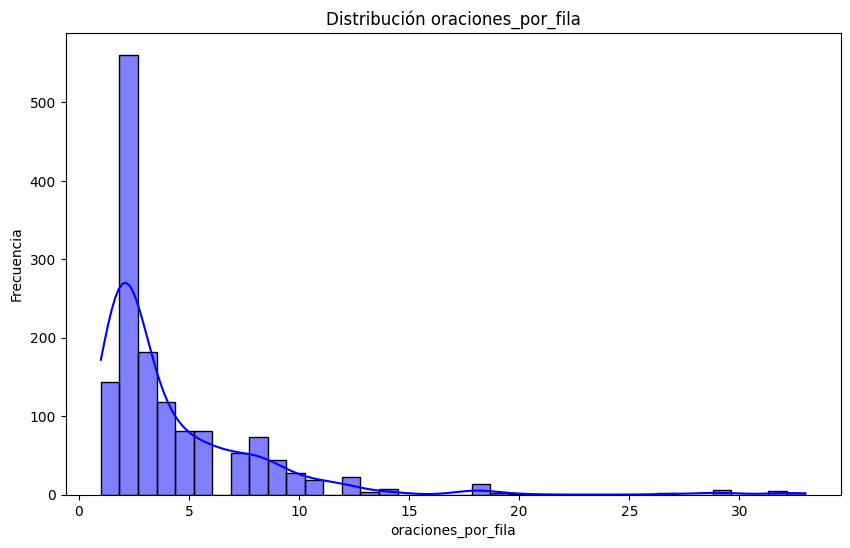

In [50]:
bins=int(round(np.sqrt(len(corpus)),0))
#histogramas
for i in list(corpus.columns)[1:]:
  plt.figure(figsize=(10, 6))
  sns.histplot(corpus[i], bins=bins, kde=True, color='blue')
  plt.title(f"Distribución {i}")
  plt.xlabel(i)
  plt.ylabel("Frecuencia")
  plt.show()

A continuación vamos a explorar aquellas entradas con más de quince oraciones por fila.

In [51]:
for i in corpus.loc[corpus['oraciones_por_fila']>15,'descripcion']:
  print(i)

CAMISOLIN DE UN SOLO USO TELA: SMS uso Médico, Barrera de 47 g/m2 (+/- 5%)  Delantero y mangas dobles con el refuerzo interno total de spundbond 40/50 g/m2, de una sóla pieza.  Espalda: Retroespaldero obligatorio. Con 4 pares de tiras que producen el cruce adecuado con técnica aséptica, dos pares para el cruce del cuello y los otros dos pares a 44 cm del borde del escote, para el cruce de la cintura.   Cuello: escote redondo, fileteado con la misma tela.   Ubicación de tirillas:    -Ajuste de cuello: Dos pares de tiras para ajuste que produzcan un cruce no menor de 10 cm. Sobre el lado derecho, una en el borde y la otra a 10 cm cara interna y sobre el lado izquierdo, una en el borde y la otra a 10 cm cara externa. Medida de tiras: 20 cm de largo aproximadamente cada una, ancho de 1,5 cm.   -Ajuste de cintura: dos pares de tiras a 44 cm del borde del escote, para producir el cruce adecuado, una sobre el borde del espaldero derecho y la otra en la costura lateral cara interna y el otro p

Parece ser que la longitud se condice con una descripcion minusiosa y no con errores de carga.
También parece ser que el elemento comprado esta descripto en mayusculas en la primera oración y el resto es descripción vamos a probar esta hipótesis  seleccionando 10 entradas al azar.
También parece que hay servicios

In [52]:
from random import sample
for i in corpus.loc[sample(list(corpus.index),10),'descripcion']:
  print(i)

CABINA DE SEGURIDAD BIOLOGICA    Modelo: Sin flujo laminar, con capacidad para introducir el equipamiento de PCR (Polymerasa Chain Reaction), con descontaminación por radiación ultravioleta (UVC) para evitar contaminación cruzada, con timer, con interruptor de seguridad ante la apertura Variedad: Sin flujo laminar 
MAMELUCO DE SEGURIDAD ESPECIFICACIONES DE LA TELA.:  Tela no tejida de oleafina termosoldada tipo Tyvek. Con revestimiento de polietileno de alta densidad. Deberá poseer una superficie lisa y antiestática repelente a la contaminación.  COLOR: Blanco  NORMAS DE CONFECCION:  Extraespaciosos en las áreas que se requiera presión en los movimientos.  Cierre antiestático de tamaño completo.  Usos: Para tareas que requieran una eficaz barrera contra líquidos en general,  ácidos altamente corrosivos y solventes orgánicos mas comunes.  Nota: la elección de los tipos de prendas  mas adecuadas para la tarea que realicen los agentes, quedará a cargo de la repartición solicitante. Modelo

In [53]:
for i in corpus.loc[corpus['descripcion'].str.contains('SERVICIO'),'descripcion'].unique():
  print(i)


SERVICIO DE REPARACION INTEGRAL DE NEUMOINSUFLADOR    Marca: Storz Modelo: Marca STORZ, modelo Thermoflator, el servicio incluye mano de obra e insumos para su correcto funcionamiento Variedad: Neumoinsuflador 
SERVICIO DE REPARACION INTEGRAL DE OXIMETRO DE PULSO . Marca: Nellcor Modelo: Marca NELLCOR, modelo NPB 600X, el servicio incluye mano de obra e insumos para su correcto funcionamiento Variedad: Oximetro de pulso 
SERVICIO DE REPARACION INTEGRAL DE MONITOR MULTIPARAMETRICO . Modelo: Marca GENERAL ELECTRIC, modelo CareScape, el servicio incluye mano de obra e insumos para su correcto funcionamiento. 
SERVICIO DE REPARACION INTEGRAL DE OXIMETRO DE PULSO    Marca: Mindray Modelo: Marca MINDRAY, Modelo VS-800, el servicio incluye mano de obra e insumos para su correcto funcionamiento Variedad: Oximetro de pulso 
SERVICIO DE VALIDACION DE CABINA PARA SEGURIDAD BIOLOGICA . Modelo: Marca TELSTAR, según normas NSF STD 49, BS 5726-5296, Federal STD 209/E y MIL 51068 C, con tests de: unif

parecería haber tres grandes grupos, servicios, alquileres y compras (por defecto esta ultima). Veamos si no hay alguna otra categoría

In [54]:
for i in corpus.loc[~(corpus['descripcion'].str.contains('SERVICIO')) & ~(corpus['descripcion'].str.contains('ALQUILER')),'descripcion'].unique():
  print(i)

BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS . Modelo: De polipropileno virgen,no tóxico.Con doble compartimiento para la muestra y el protocolo de trabajo,con solapa de cierre definitivo.
MICROPIPETA AUTOMATICA Modelo: De volumen variable de 100-1000µL, con cuerpo y extremidad resistente a los agentes quimicos agresivos, con display digital, para ser utilizadas con tips universales, con eyector de tips incorporado al cuerpo de la pipeta.
MICROPIPETA AUTOMATICA Modelo: De volumen variable de 10-100 µL, con cuerpo y extremidad resistente a los agentes qumicos agresivos, con display digital, para ser utilizadas con tips universales, con eyector de tips incorporado al cuerpo de la pipeta.
PUNTA PARA PIPETA (TIP) Modelo: Azul, plástica
CANULA PARA TRAQUEOSTOMIA SIN BALON b) Un repuesto de cánula interior de 10 mm de diámetro interno. c) Una válvula de una vía con adaptador para Luer y Luer-Lock, y obturador, d) Un collarín de fijación, e) Un tirante elástico de 44 cm de largo. Estéril, ató

Efectivamente, las tres grandes categorias parecerían ser compras, servicios y alquileres.
Vamos a hacer variables tipo one hot para luego poder separarlas.
Vamos a separar la descripcion del titulo.

In [55]:
corpus['servicio']=np.where(corpus['descripcion'].str.contains('SERVICIO'),True,False)
corpus['alquiler']=np.where(corpus['descripcion'].str.contains('ALQUILER'),True,False)
corpus['compras']=np.where(~(corpus['descripcion'].str.contains('SERVICIO')) & ~(corpus['descripcion'].str.contains('ALQUILER')),True,False)
corpus.head()

,descripcion,caracteres_por_fila,palabras_por_fila,caracteres_especiales_por_fila,oraciones_por_fila,servicio,alquiler,compras
0,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....,188,26,6,4,False,False,True
1,MICROPIPETA AUTOMATICA Modelo: De volumen vari...,253,37,8,2,False,False,True
2,MICROPIPETA AUTOMATICA Modelo: De volumen vari...,251,38,8,2,False,False,True
3,"PUNTA PARA PIPETA (TIP) Modelo: Azul, plástica",46,7,4,1,False,False,True
4,BOLSA PARA TRANSPORTE DE MUESTRAS BIOLOGICAS ....,188,26,6,4,False,False,True


In [56]:
def extract_uppercase_text(text):
   # genero una columna con el elemento
    match = re.match(r'^([A-ZÁÉÍÓÚÑ\s]+)', str(text))
    return match.group(0).strip() if match else ''
corpus['elemento']=corpus.descripcion.apply(extract_uppercase_text)
# Define the conditions and replacements in a dictionary for clarity
conditions_replacements = {
    'ANTISUERO ANTI ALFA': 'ANTISUERO ANTI ALFA 1 ANTITRIPSINA HUMANA',
    'BUDESONIDA + FORMOTEROL': 'BUDESONIDA + FORMOTEROL',
    'OXIMETRO DE PULSO - SATUROMETRO - PULSIOXIMETRO': 'OXIMETRO DE PULSO - SATUROMETRO - PULSIOXIMETRO',
    'CABLE ARMADO - CABLE EXTENSION PARA SENSOR DE OXIMETRIA': 'CABLE ARMADO - CABLE EXTENSION PARA SENSOR DE OXIMETRIA',
    'CABLE ARMADO - CABLE SENSOR DE TEMPERATURA DE PACIENTE': 'CABLE ARMADO - CABLE SENSOR DE TEMPERATURA DE PACIENTE',
    'CABLE ARMADO - CABLE SENSOR DE PULSO': 'CABLE ARMADO - CABLE SENSOR DE PULSO',
    'CABLE ARMADO - CABLE SENSOR DE OXIMETRIA': 'CABLE ARMADO - CABLE SENSOR DE OXIMETRIA',
    'CABLE ARMADO - CABLE TRONCAL PARA ECG': 'CABLE ARMADO - CABLE TRONCAL PARA ECG',
    'CABLE ARMADO - CABLE EXTENSION PARA SATUROMETRIA': 'CABLE ARMADO - CABLE EXTENSION PARA SENSOR DE OXIMETRIA',
    'BARBIJO TIPO MASCARILLA DE ALTA EFICIENCIA N95': 'BARBIJO TIPO MASCARILLA DE ALTA EFICIENCIA N95',
    'CABLE ARMADO - CABLE PARA MEDICION DE PRESION NO INVASIVA': 'CABLE ARMADO - CABLE PARA MEDICION DE PRESION NO INVASIVA',
    'KIT RT-PCR (TRANSCRIPCION REVERSA Y PCR)': 'KIT RT-PCR (TRANSCRIPCION REVERSA Y PCR)',
    'ANTICUERPO IgM e IgG  VIRUS DEL DENGUE': 'ANTICUERPO IgM e IgG  VIRUS DEL DENGUE',
    'SENSOR . Modelo: Para saturometro': 'OXIMETRO DE PULSO - SATUROMETRO - PULSIOXIMETRO',
    'CABLE ARMADO Modelo: ECG latiguillo.Set de tres latiguillos,reusable.Para equipo de monitoreo': 'CABLE ARMADO - CABLE TRONCAL PARA ECG',
    'SUERO HEMOTIPIFICADOR ANTI - c': 'SUERO HEMOTIPIFICADOR ANTI - c',
    'SUERO HEMOTIPIFICADOR ANTI - B': 'SUERO HEMOTIPIFICADOR ANTI - B',
    'SUERO HEMOTIPIFICADOR ANTI - A': 'SUERO HEMOTIPIFICADOR ANTI - A',
    'SUERO HEMOTIPIFICADOR ANTI - E': 'SUERO HEMOTIPIFICADOR ANTI - E',
    'SUERO HEMOTIPIFICADOR ANTI - D': 'SUERO HEMOTIPIFICADOR ANTI - D',
    'CABLE ARMADO - CABLE PACIENTE': 'CABLE ARMADO - CABLE PACIENTE',
    'CABLE ARMADO - CABLE PARA TEMPERATURA CORPORAL': 'CABLE ARMADO - CABLE PARA TEMPERATURA CORPORAL',
    'CEFTAZIDIME + AVIBACTAM': 'CEFTAZIDIME + AVIBACTAM'
}

# Apply each condition and replacement to the 'elemento' column
for search_text, replacement in conditions_replacements.items():
    mask = corpus['descripcion'].apply(lambda x: search_text in str(x))
    corpus.loc[mask, 'elemento'] = replacement
corpus['elemento'] = corpus['elemento'].str.replace(r'\s+[A-Z]$', '', regex=True)
corpus['elemento'] = corpus['elemento'].str.strip()
corpus['elemento'] = corpus['elemento'].apply(lambda x: x.lower())


## Remoción de stopwords

In [57]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


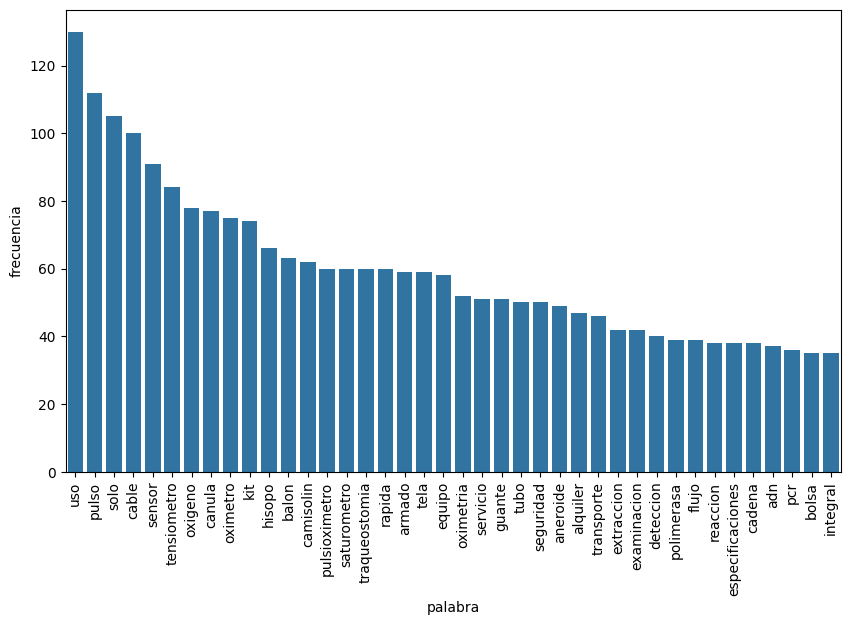

In [58]:
stop_words = set(stopwords.words('spanish'))
stop_words.add('-')
palabras=[]
for i in corpus['elemento']:
  for j in i.split():
    palabras.append(j)
palabras=[p for p in palabras if p not in stop_words]
conteo_palabras=Counter(palabras)
df_conteo_palabras=pd.DataFrame(conteo_palabras.items(),columns=['palabra','frecuencia'])
plt.figure(figsize=(10, 6))
sns.barplot(x='palabra',y='frecuencia',data=df_conteo_palabras.sort_values(by='frecuencia',ascending=False).head(40))
plt.xticks(rotation=90)
plt.show()

El uso de token hace que se pierda el sentido del elemento
ejemplo mascara de oxigeno no es lo mismo que tubo de oxigeno
voy a tener que usar Ngrams para determinar mejor los elementos

Debido a que ya tengo identificado que es compra, alquiler o servicio, voy a remover estas palabras para que no entorpescan la generacion de ngrams

<ipython-input-59-f675408b5802>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-59-f675408b5802>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


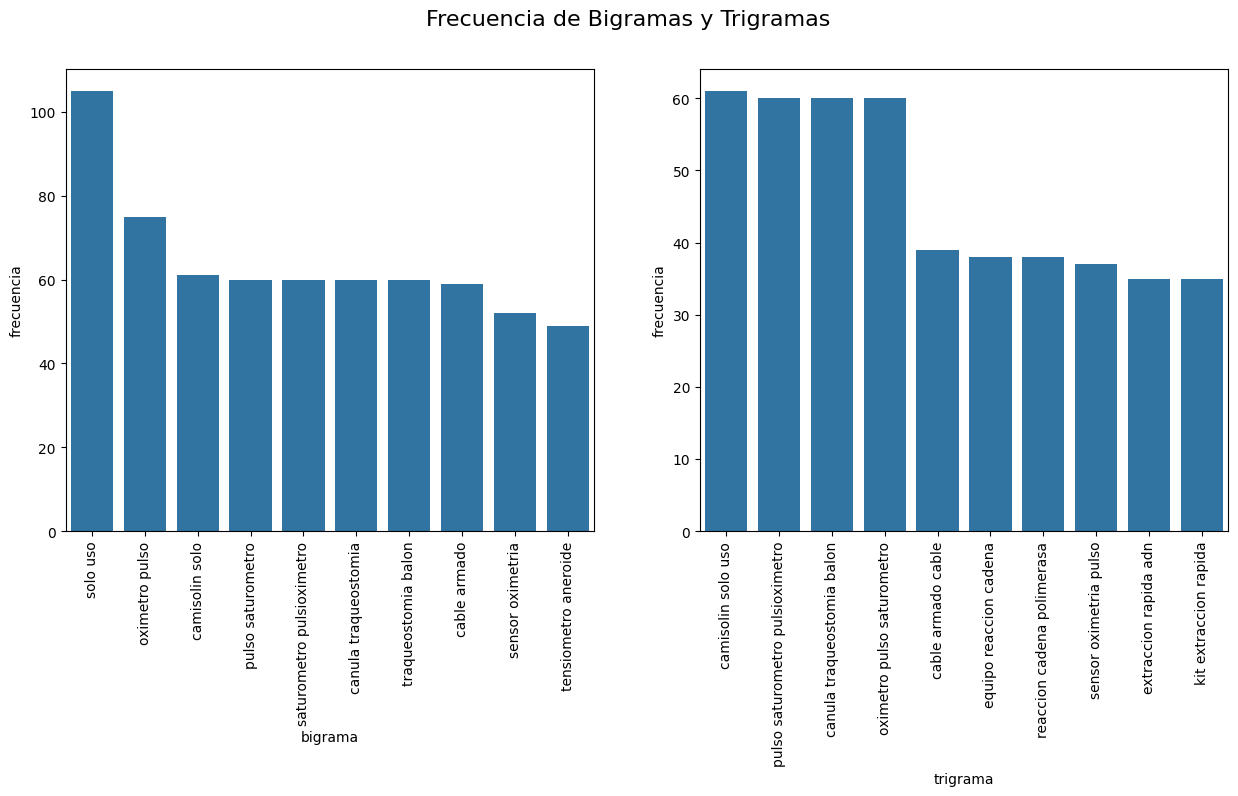

In [59]:
def generar_ngrams_filtrado(texto, n):
    tokens = [palabra for palabra in texto.split() if palabra not in stop_words]
    return list(ngrams(tokens, n))

# Creamos nuevas listas para bigramas y trigramas sin stopwords
bigramas_filtrados=[]
trigramas_filtrados=[]
for texto in corpus['elemento']:
    bigramas_filtrados.extend(generar_ngrams_filtrado(texto, 2))  # Bigramas
    trigramas_filtrados.extend(generar_ngrams_filtrado(texto, 3))  # Trigramas

# Contamos los bigramas y trigramas
conteo_bigramas = Counter(bigramas_filtrados)
conteo_trigramas = Counter(trigramas_filtrados)
df_bigramas = pd.DataFrame(conteo_bigramas.items(), columns=['bigrama', 'frecuencia'])
df_trigramas = pd.DataFrame(conteo_trigramas.items(), columns=['trigrama', 'frecuencia'])
df_bigramas['bigrama'] = df_bigramas['bigrama'].apply(lambda x: ' '.join(x))
df_trigramas['trigrama'] = df_trigramas['trigrama'].apply(lambda x: ' '.join(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Frecuencia de Bigramas y Trigramas', fontsize=16)
sns.barplot(x='bigrama', y='frecuencia', data=df_bigramas.sort_values(by='frecuencia', ascending=False).head(10), ax=axs[0])
sns.barplot(x='trigrama', y='frecuencia', data=df_trigramas.sort_values(by='frecuencia', ascending=False).head(10), ax=axs[1])
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

hay palabras que no agregan significado como cable y armado


<ipython-input-60-bd16f1bde46d>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-60-bd16f1bde46d>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


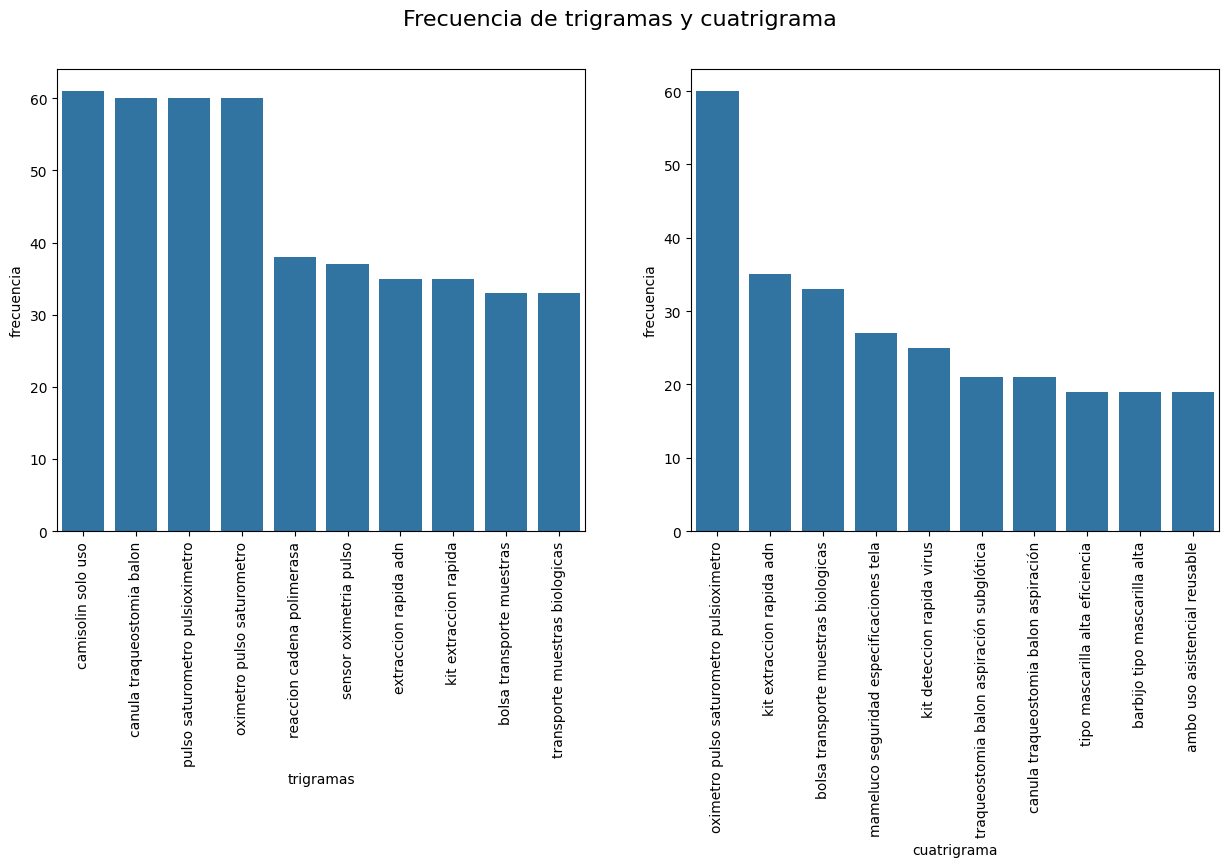

In [60]:
stop_words = set(stopwords.words('spanish'))
#agrego servicio, alquiler, equipo
nuevas_stopwords = ['cable', 'armado','-','servicio','alquiler','equipo','dispositivo','reparacion']
stop_words.update(nuevas_stopwords)
def generar_ngrams_filtrado(texto, n):
    tokens = [palabra for palabra in texto.split() if palabra not in stop_words]
    return list(ngrams(tokens, n))

# Creamos nuevas listas para bigramas y trigramas sin stopwords
trigramas_filtrados=[]
cuatrigramas_filtrados=[]
for texto in corpus['elemento']:
    trigramas_filtrados.extend(generar_ngrams_filtrado(texto, 3))  # Trigramas
    cuatrigramas_filtrados.extend(generar_ngrams_filtrado(texto, 4))  # cuatrigramas

# Contamos los bigramas y trigramas
conteo_trigramas = Counter(trigramas_filtrados)
conteo_cuatrigramas = Counter(cuatrigramas_filtrados)
df_trigramas = pd.DataFrame(conteo_trigramas.items(), columns=['trigramas', 'frecuencia'])
df_cuatrigramas = pd.DataFrame(conteo_cuatrigramas.items(), columns=['cuatrigrama', 'frecuencia'])
df_trigramas['trigramas'] = df_trigramas['trigramas'].apply(lambda x: ' '.join(x))
df_cuatrigramas['cuatrigrama'] = df_cuatrigramas['cuatrigrama'].apply(lambda x: ' '.join(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Frecuencia de trigramas y cuatrigrama', fontsize=16)
sns.barplot(x='trigramas', y='frecuencia', data=df_trigramas.sort_values(by='frecuencia', ascending=False).head(10), ax=axs[0])
sns.barplot(x='cuatrigrama', y='frecuencia', data=df_cuatrigramas.sort_values(by='frecuencia', ascending=False).head(10), ax=axs[1])
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [61]:
df_cuatrigramas.sort_values(by='frecuencia', ascending=False)[10:30]

,cuatrigrama,frecuencia
16,mascarilla alta eficiencia n95,18
66,test rapido deteccion antigeno,15
67,rapido deteccion antigeno sars,15
5,camisolin solo uso tela,12
27,solo uso especificaciones tela,11
33,rt-pcr (transcripcion reversa pcr),10
32,kit rt-pcr (transcripcion reversa,10
24,medidor flujo aire comprimido,10
7,uso asistencial reusable tela,8
19,mascara oxigeno rostro completo,7


Como se puede ver hay muchos elementos que se repiten como diferentes entradas debido a la longitud de la descripción. Ejemplo: traqueostomia balon dispositivo aspiracion y balon dispoitivo aspiracion. Al ser 125 filas es manejable y dable que pueda inspeccionar y homogeneizar los cuatrigramas.

In [62]:
df_cuatrigramas['elementos_postprocesado']=''

In [63]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('traqueostomia'),:]

,cuatrigrama,frecuencia,elementos_postprocesado
60,canula traqueostomia balon aspiración,21,
61,traqueostomia balon aspiración subglótica,21,


In [64]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('traqueostomia'),'elementos_postprocesado']='canula traqueostomia'

In [65]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('mascarilla'),:]

,cuatrigrama,frecuencia,elementos_postprocesado
14,barbijo tipo mascarilla alta,19,
15,tipo mascarilla alta eficiencia,19,
16,mascarilla alta eficiencia n95,18,
22,mascarilla oxigeno nasal cpap,3,
76,barbijo tipo mascarilla solo,1,
77,tipo mascarilla solo uso,1,
86,mascarilla alta eficiencia kn,1,


In [66]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='barbijo tipo mascarilla alta','elementos_postprocesado']='barbijo alta eficiencia n95'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='tipo mascarilla alta eficiencia','elementos_postprocesado']='barbijo alta eficiencia n95'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='mascarilla alta eficiencia n95','elementos_postprocesado']='barbijo alta eficiencia n95'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='mascarilla alta eficiencia kn','elementos_postprocesado']='barbijo alta eficiencia n95'

In [67]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('solo uso especificaciones'),:]

,cuatrigrama,frecuencia,elementos_postprocesado
26,bata solo uso especificaciones,7,
27,solo uso especificaciones tela,11,
45,camisolin solo uso especificaciones,4,


In [68]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='bata solo uso especificaciones','elementos_postprocesado']='bata descartable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='solo uso especificaciones tela','elementos_postprocesado']='bata descartable'


In [69]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('camisolin'),:]

,cuatrigrama,frecuencia,elementos_postprocesado
5,camisolin solo uso tela,12,
45,camisolin solo uso especificaciones,4,


In [70]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='camisolin solo uso tela','elementos_postprocesado']='camisolin descartable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='camisolin solo uso especificaciones','elementos_postprocesado']='camisolin descartable'


In [71]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('alfa'),:]

,cuatrigrama,frecuencia,elementos_postprocesado
2,antisuero anti alfa 1,1,
3,anti alfa 1 antitripsina,1,
4,alfa 1 antitripsina humana,1,


In [88]:
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='cilindros oxigeno medicinal paciente','elementos_postprocesado']='tubo oxigeno ambulatorio'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='oxigeno medicinal paciente ambulatorio','elementos_postprocesado']='tubo oxigeno ambulatorio'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='oximetro pulso saturometro pulsioximetro','elementos_postprocesado']='saturometro'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama'].str.contains('alfa'),'elementos_postprocesado']='antisuero anti alfa 1 antitripsina humana'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='bolsa transporte muestras biologicas','elementos_postprocesado']='bolsa transporte muestras biologicas'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='tubo medio transporte hisopo','elementos_postprocesado']='medio transporte hisopo'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='ambo uso asistencial reusable','elementos_postprocesado']='ambo reusable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='uso asistencial reusable tela','elementos_postprocesado']='ambo reusable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='sistema cerrado aspiracion ventilacion','elementos_postprocesado']='sistema de aspiracion para ventilador'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='reactivos determinacion anticuerpos especificos','elementos_postprocesado']='reactivos de determinacion anticuerpos'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='kit extraccion rapida adn','elementos_postprocesado']='kit extraccion rapida adn'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='kit extraccion adn','elementos_postprocesado']='kit extraccion adn'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='ambo cirugia solo uso	','elementos_postprocesado']='ambo descartable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='kit extraccion adn','elementos_postprocesado']='kit extraccion adn'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='mameluco seguridad especificaciones tela','elementos_postprocesado']='mameluco de tela de seguridad'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='kit rt-pcr (transcripcion reversa','elementos_postprocesado']='kit rt-pcr'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='rt-pcr (transcripcion reversa pcr)','elementos_postprocesado']='kit rt-pcr'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='anticuerpo igm igg virus','elementos_postprocesado']='anticuerpo igm igg virus dengue'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='igm igg virus dengue','elementos_postprocesado']='anticuerpo igm igg virus dengue'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='mantenimiento preventivo correctivo sistema','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='preventivo correctivo sistema digitalizacion','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='correctivo sistema digitalizacion imagenesn','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='sistema digitalizacion imagenes metodo','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='digitalizacion imagenes metodo cr','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='correctivo sistema digitalizacion imagenes','elementos_postprocesado']='mantenimiento preventivo sistema digital de imagenes'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='reductor baja presion aire','elementos_postprocesado']='reductor de presion de aire'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='baja presion aire comprimido','elementos_postprocesado']='reductor de presion de aire'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='termometro electronico digital doble','elementos_postprocesado']='termometro digital doble sensor'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='electronico digital doble sensor','elementos_postprocesado']='termometro digital doble sensor'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='digital doble sensor medio','elementos_postprocesado']='termometro digital'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='doble sensor medio ambiente','elementos_postprocesado']='termometro digital'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='cabina seguridad biologica clase','elementos_postprocesado']='cabina de seguridad biologica'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='seguridad biologica clase','elementos_postprocesado']='cabina de seguridad biologica'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='seguridad biologica clase ii','elementos_postprocesado']='cabina de seguridad biologica'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='validacion cabina seguridad biologica','elementos_postprocesado']='cabina de seguridad biologica'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='integral cabina seguridad biologica','elementos_postprocesado']='cabina de seguridad biologica'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='canula traqueotomia linea aspiracion','elementos_postprocesado']='canula traqueotomia'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='traqueotomia linea aspiracion subglotica','elementos_postprocesado']='canula traqueostomia'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='test rapido deteccion antigeno','elementos_postprocesado']='test deteccion rapida antigeno SARS'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='rapido deteccion antigeno sars','elementos_postprocesado']='test deteccion rapida antigeno SARS'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='anti inmunoglobulina g humana','elementos_postprocesado']='igg humana cabra conejo'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='inmunoglobulina g humana cabra','elementos_postprocesado']=' anti igg humana cabra conejo'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='g humana cabra conejo','elementos_postprocesado']=' anti igg humana cabra conejo'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='barbijo tipo mascarilla solo','elementos_postprocesado']='barbijo descartable'
df_cuatrigramas.loc[df_cuatrigramas['cuatrigrama']=='tipo mascarilla solo uso','elementos_postprocesado']='barbijo descartable'



In [89]:
for i in df_cuatrigramas.index:
  if df_cuatrigramas.loc[i,'elementos_postprocesado']=='':
    df_cuatrigramas.loc[i,'elementos_postprocesado']=df_cuatrigramas.loc[i,'cuatrigrama']

## Visualización en word cloud

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
from PIL import Image
from wordcloud import WordCloud


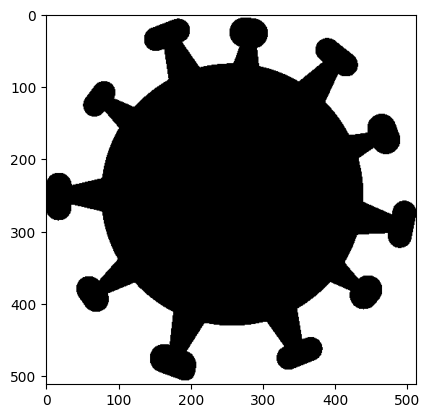

In [112]:
input_image = Image.open('/content/drive/MyDrive/portfolio/coronavirus.png')
pixel_map = input_image.load()
width, height = input_image.size

for i in range(width):
    for j in range(height):

        # getting the RGB pixel value.
        r, g, b, p = input_image.getpixel((i, j))

        grayscale = (0.299*r + 0.587*g + 0.114*b)

        # setting the pixel value.
        pixel_map[i, j] = (int(grayscale), int(grayscale), int(grayscale))
        if pixel_map[i, j] == (0, 0, 0,255):
          pixel_map[i, j] = (255, 255, 255,255)
        else:
          pixel_map[i, j] = (0, 0, 0,255)

        #else:
         # pixel_map[i, j] = (0, 0, 0)

mask=np.array(input_image)

# Use imshow to display the image data
plt.imshow(mask)  # Use imshow for image data
plt.show()

In [113]:
wordcloud=df_cuatrigramas.groupby('elementos_postprocesado')['frecuencia'].sum().sort_values(ascending=False).reset_index()
wordcloud.head()
frequencies = wordcloud.set_index('elementos_postprocesado')['frecuencia'].to_dict()

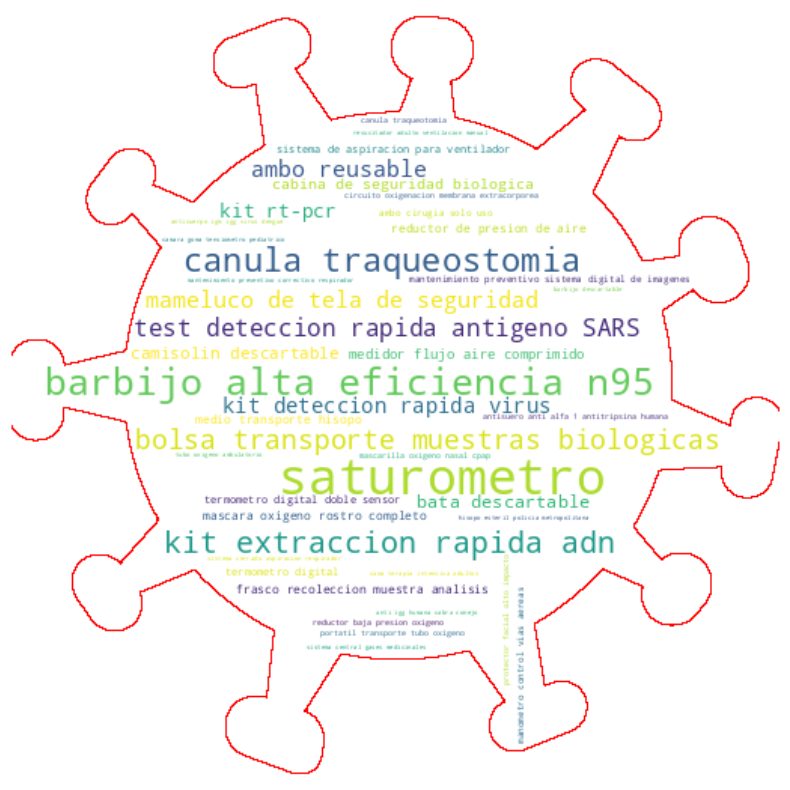

In [115]:
wordcloud = wordcloud = WordCloud(width=800, height=800, background_color='white', mask=mask, contour_width=1, contour_color='red').generate_from_frequencies(frequencies)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()